# Approximation of a Quadratic Function Using PICNN Architecture

Consider the parameterized quadratic function
$$q\colon\mathbb{R}\times\mathbb{R}\to\mathbb{R},\quad (u, \eta)\mapsto (u-\eta/2)^2$$

We will approximate $q$ using the PICNN architecture introduced by [Amos et al.](https://arxiv.org/abs/1609.07152).

Begin by importing the relevant packages:

In [ ]:
import torch
from ml_adp.mapping.convex import PICNN

from tqdm import tqdm
import matplotlib.pyplot as plt

Implement $q$:

In [3]:
def q(input, param):
    return (input - param / 2) ** 2

We wrap ``q`` into a single-step :py:code:`CostToGo`-instance (to better illustrate the application of PICNN's during solution of actual optimal control problems using value function approximation).

In [4]:
from ml_adp.cost import CostToGo

In [5]:
quadratic = CostToGo.from_steps(0)
quadratic.cost_functions[0] = q

quadratic

CostToGo(
 step |      state_func      |     control_func     |      cost_func       
    0                                  None                   q(-)         
   (1)          None                                                       
)

We create another single-step :py:code:`CostToGo` whose cost function is a PICNN.
We rely on two hidden layers for both the output net and the parameter net; for the output net we use 30 neurons each, for the parameter net we use 80 neurons each.
Additionally, we'll choose the $\mathrm{ELU}$ activation function for both the ouput and the parameter net since the target function is smooth.

In [25]:
approximator = CostToGo.from_steps(0)

picnn_config = {
    'output_net_size': (1, 60, 60, 1),
    'param_net_size': (1, 60, 60, 1),
    'output_net_hidden_activation': torch.nn.ELU(),
    'param_net_config': {
        'hidden_activation': torch.nn.ELU()
    }
}

approximator.cost_functions[0] = PICNN(**picnn_config)

approximator

CostToGo(
 step |      state_func      |     control_func     |      cost_func       
    0                                  None               PICNN(train)     
   (1)          None                                                       
)

We care about approximating $q$ on $A = [-25, 25]\times [-25, 25]\subseteq \mathrm{dom}(q)$.
Accordingly, we'll sample uniformly from $A$:

In [26]:
from torch.distributions.uniform import Uniform

sampler = Uniform(-25. , 25.)

We optimize the parameters of the output net and modules of the parameter net of the PICNN separately.

In [27]:
output_net_lr = 1e-3
param_net_lr = 1e-2

optimizer = torch.optim.Adam(
    approximator.cost_functions[0].output_net_modules.parameters(),
    lr=output_net_lr
)

optimizer.add_param_group({
    'params': approximator.cost_functions[0].param_net_modules.parameters(),
    'lr': param_net_lr
})

Choose the optimization loop and batching parameters:

In [28]:
gradient_descent_iterations = 1000
batch_size = 500

Perform the optimization:

In [29]:
iterations = tqdm(range(gradient_descent_iterations))

for _ in iterations:
    
    inputs = sampler.sample((batch_size, 1))
    params = sampler.sample((1, batch_size, 1))
    
    values = quadratic(inputs, params)
    approximate_values = approximator(inputs, params)
    
    approximation_error = torch.norm(values - approximate_values, p=2)
    
    approximation_error.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    iterations.set_description(
        f"Approximation Error: {approximation_error:9.4f}"
    )

Approximation Error:  403.1594: 100%|==========| 1000/1000 [00:34<00:00, 28.63it/s]


Plot the result:

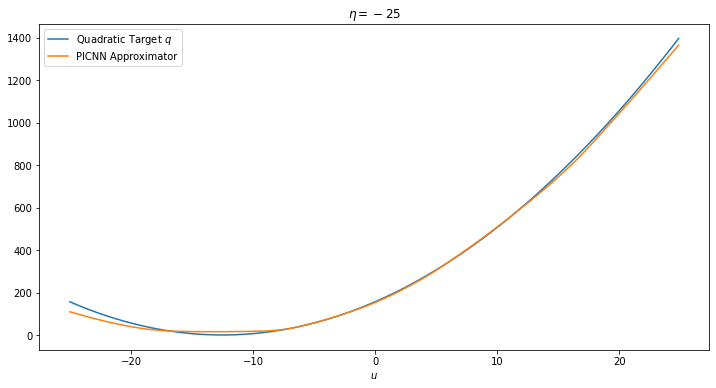

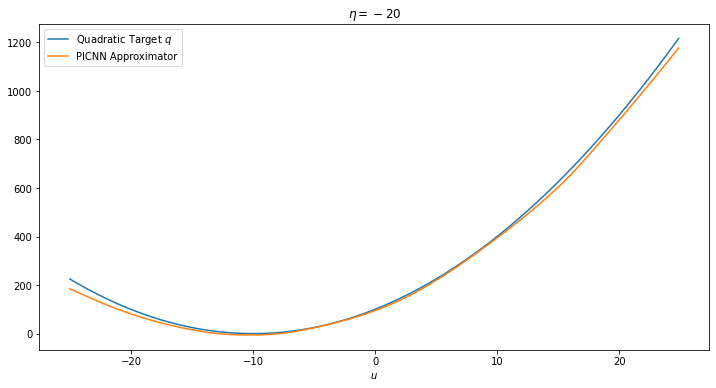

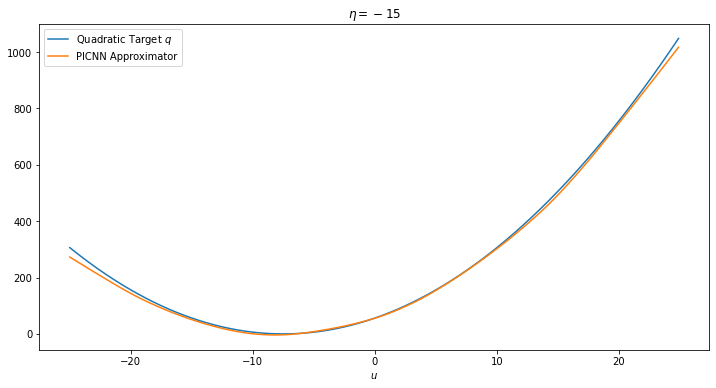

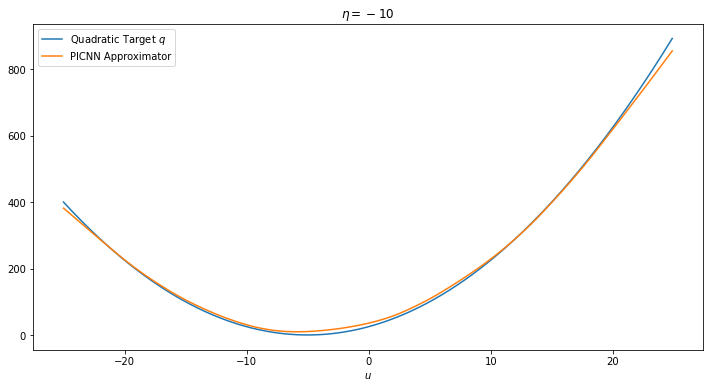

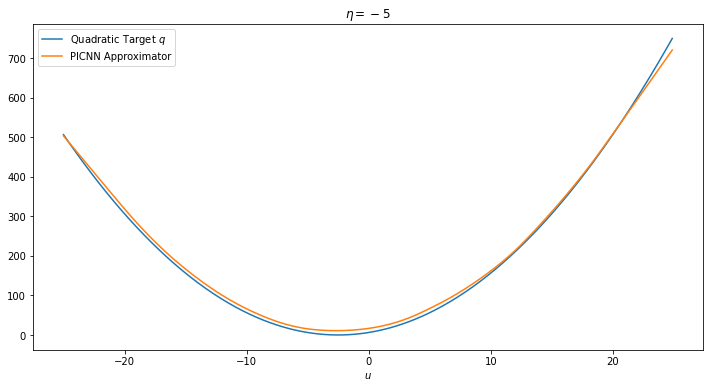

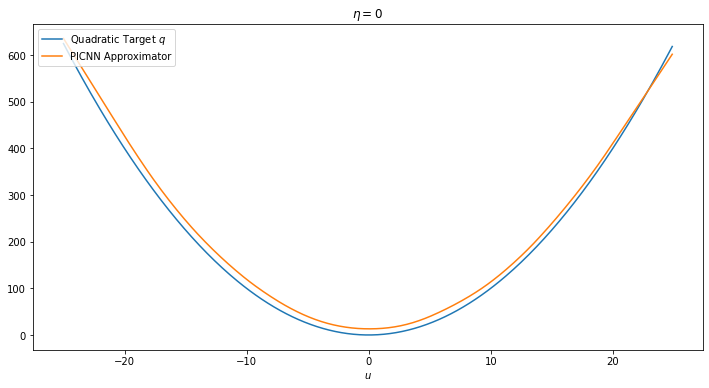

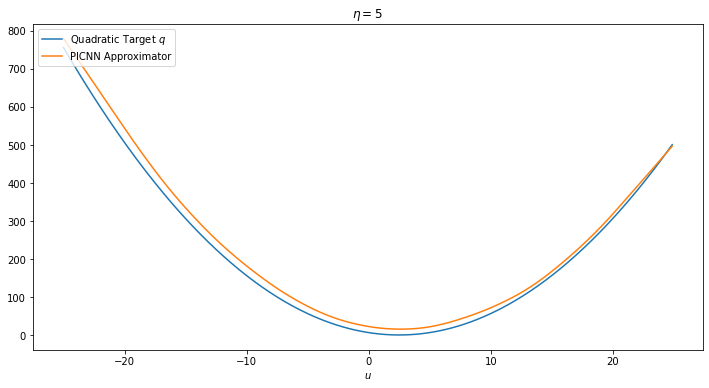

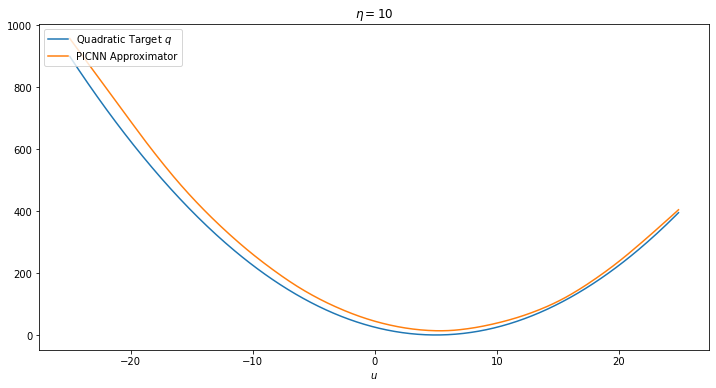

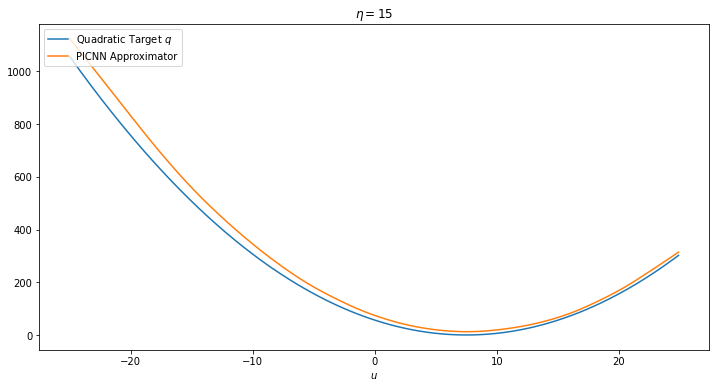

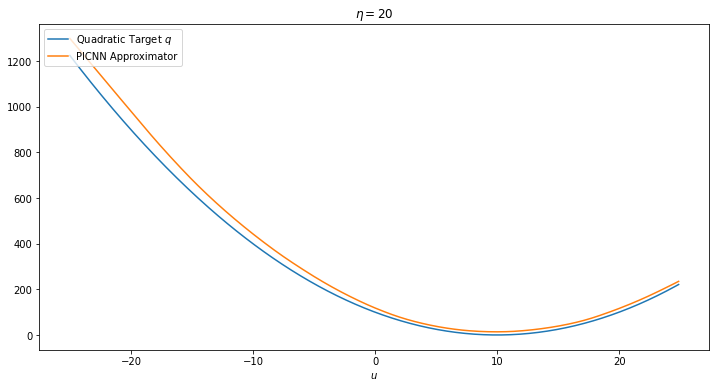

In [24]:
from ml_adp.cost import _evaluating

with _evaluating(approximator):
    for param in range(-25, 25, 5):
        
        rng = torch.arange(-25, 25, .125).unsqueeze(1)
        param_rng = param * torch.ones(len(rng)).unsqueeze(1)
        
        vals = quadratic(rng, param_rng).squeeze().numpy()
        approx_vals = approximator(rng, param_rng).detach().squeeze().numpy()
       
        plt.figure(figsize=(12,6)) 
        plt.plot(rng.numpy(), vals, label=r'Quadratic Target $q$')
        plt.plot(rng.numpy(), approx_vals, label='PICNN Approximator')
        plt.legend(loc='upper left')
        plt.xlabel(r'$u$')
        plt.title(fr'$\eta = {param}$')
        
        plt.show()
        